In [ ]:
import sys
import os
import time
import json
import random
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
import mlflow
import mlflow.pytorch



if not torch.cuda.is_available():
    print("ERROR: No GPU detected. This pipeline is configured to run strictly on CUDA.")
    sys.exit(1)

# Configuration

CONFIG = {
    "SEED": 42,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-3,
    "EPOCHS": 50,
    "TEST_SIZE": 0.20,    
    "IMAGE_SIZE": 32,
    "DEVICE": torch.device("cuda"),
    "WEIGHT_DECAY": 1e-4,
    "EARLY_STOP_PATIENCE": 8,
    "LR_PLATEAU_PATIENCE": 3,
    "LR_PLATEAU_FACTOR": 0.5,
}

print(f"Running on device: {CONFIG['DEVICE']}")



Running on device: cuda


In [11]:
class EEGProcessor:
    def __init__(self, filepath, target_dim=1024):
        self.filepath = filepath
        self.target_dim = target_dim
        self.encoder = LabelEncoder()
        self.imputer = SimpleImputer(strategy="mean")

        # Metadata + known junk column(s) to drop
        self.drop_cols = [
            "no.", "sex", "age", "eeg.date", "education", "IQ",
            "main.disorder", "specific.disorder",
            "Unnamed: 122",  
        ]

        self.target_classes = ["Depressive disorder", "Healthy control"]

    def load_and_process(self):
        print(f"Loading {self.filepath}...")
        try:
            df = pd.read_csv(self.filepath)
        except FileNotFoundError:
            sys.exit(f"Error: File {self.filepath} not found.")

        # --- Filter to target classes ---
        if "specific.disorder" not in df.columns:
            sys.exit("Error: Column 'specific.disorder' not found.")

        df = df[df["specific.disorder"].isin(self.target_classes)].copy()

        # --- Labels ---
        y_raw = df["specific.disorder"].values
        y = self.encoder.fit_transform(y_raw)

        # --- Drop metadata + junk columns ---
        df = df.drop(columns=[c for c in self.drop_cols if c in df.columns], errors="ignore")

        # Ensure numeric (defensive)
        df = df.apply(pd.to_numeric, errors="coerce")

        # --- Impute missing values 
        if df.isna().any().any():
            print("Found missing values. Filling with column means...")
            X = self.imputer.fit_transform(df)
        else:
            print("No missing values found.")
            X = df.to_numpy()

        # --- Trim/pad to target_dim (default 1024) ---
        n_features = X.shape[1]
        if n_features >= self.target_dim:
            X = X[:, : self.target_dim]
        else:
            pad = np.zeros((X.shape[0], self.target_dim - n_features), dtype=X.dtype)
            X = np.hstack([X, pad])

        X = X.astype(np.float32)
        print(f"Final Feature Matrix: {X.shape}")
        return X, y


processor = EEGProcessor("../dataset/EEG.csv", target_dim=1024)
X, y = processor.load_and_process()

Loading ../dataset/EEG.csv...
No missing values found.
Final Feature Matrix: (294, 1024)


Starting Exploratory Data Analysis...
Rows after filter: 294
Class counts:
 specific.disorder
Depressive disorder    199
Healthy control         95
Name: count, dtype: int64


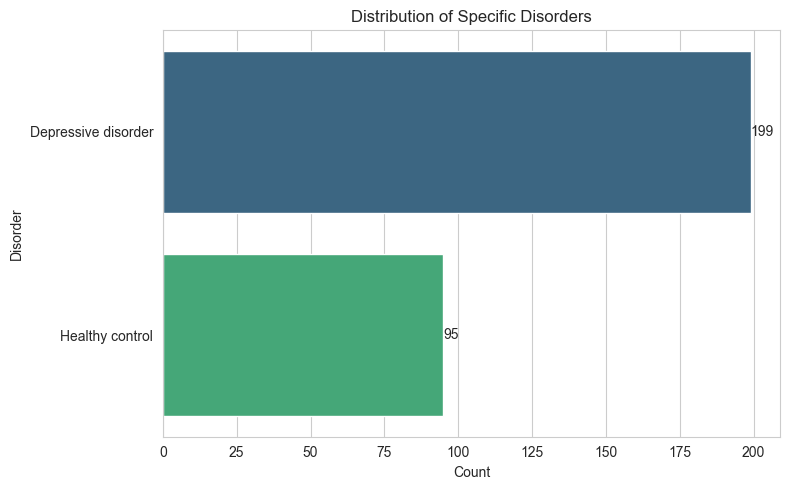

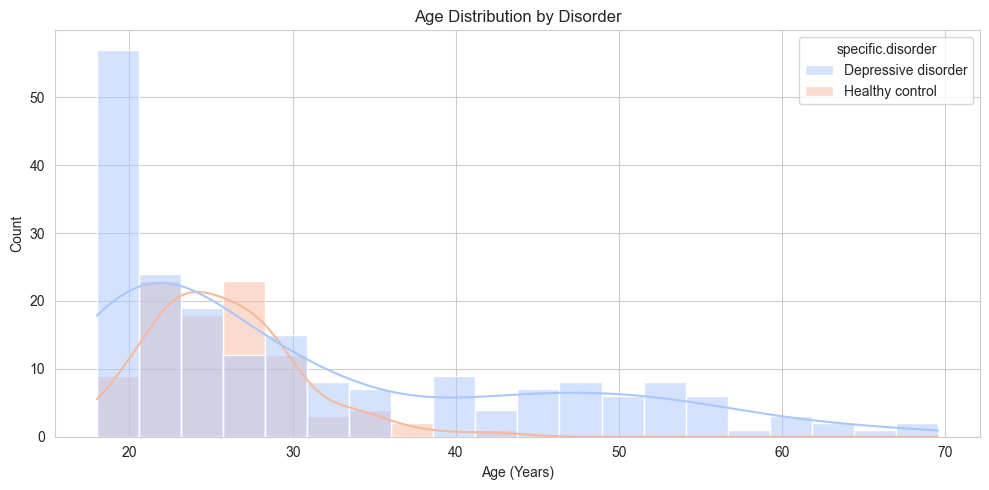

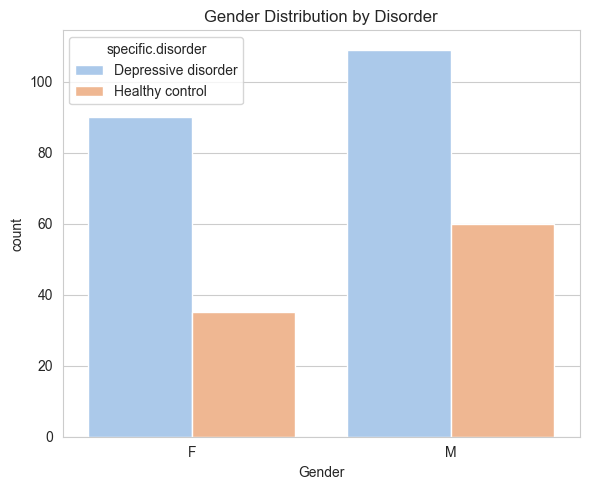

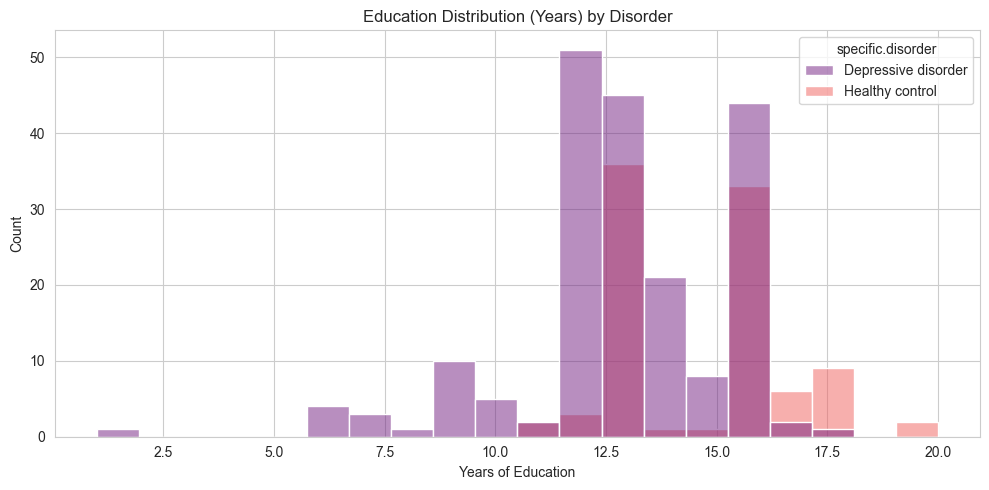

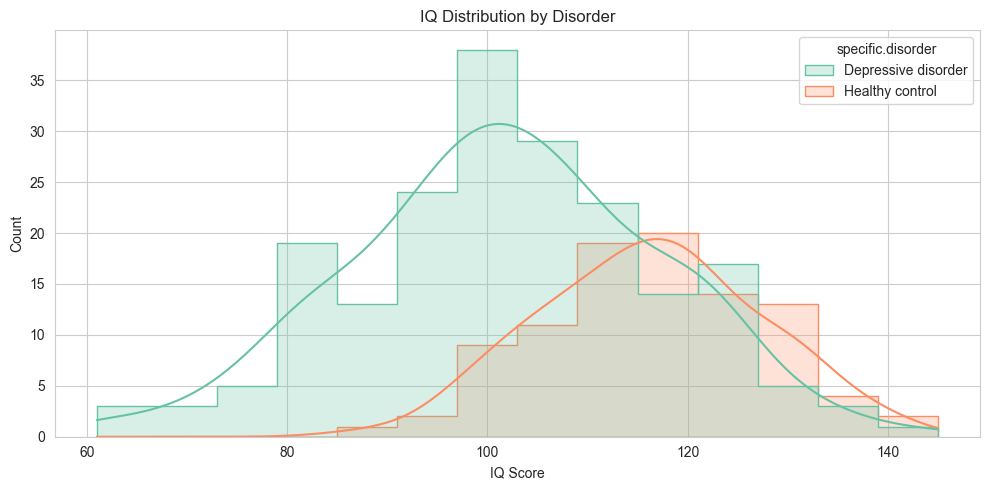


🧩 Missingness analysis (EEG features)
Top missing feature columns (%):
AB.A.delta.a.FP1    0.0
AB.A.delta.b.FP2    0.0
AB.A.delta.c.F7     0.0
AB.A.delta.d.F3     0.0
AB.A.delta.e.Fz     0.0
AB.A.delta.f.F4     0.0
AB.A.delta.g.F8     0.0
AB.A.delta.h.T3     0.0
AB.A.delta.i.C3     0.0
AB.A.delta.j.Cz     0.0
AB.A.delta.k.C4     0.0
AB.A.delta.l.T4     0.0
AB.A.delta.m.T5     0.0
AB.A.delta.n.P3     0.0
AB.A.delta.o.Pz     0.0
AB.A.delta.p.P4     0.0
AB.A.delta.q.T6     0.0
AB.A.delta.r.O1     0.0
AB.A.delta.s.O2     0.0
AB.B.theta.a.FP1    0.0
AB.B.theta.b.FP2    0.0
AB.B.theta.c.F7     0.0
AB.B.theta.d.F3     0.0
AB.B.theta.e.Fz     0.0
AB.B.theta.f.F4     0.0
AB.B.theta.g.F8     0.0
AB.B.theta.h.T3     0.0
AB.B.theta.i.C3     0.0
AB.B.theta.j.Cz     0.0
AB.B.theta.k.C4     0.0
AB.B.theta.l.T4     0.0
AB.B.theta.m.T5     0.0
AB.B.theta.n.P3     0.0
AB.B.theta.o.Pz     0.0
AB.B.theta.p.P4     0.0
AB.B.theta.q.T6     0.0
AB.B.theta.r.O1     0.0
AB.B.theta.s.O2     0.0
AB.C.alpha.a.FP1

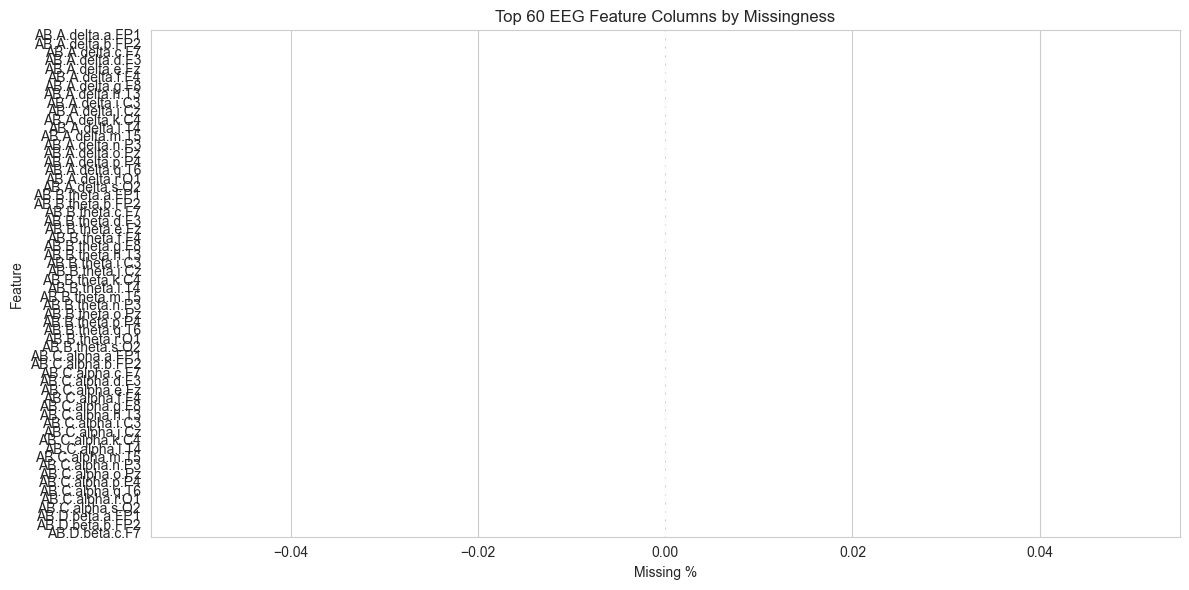

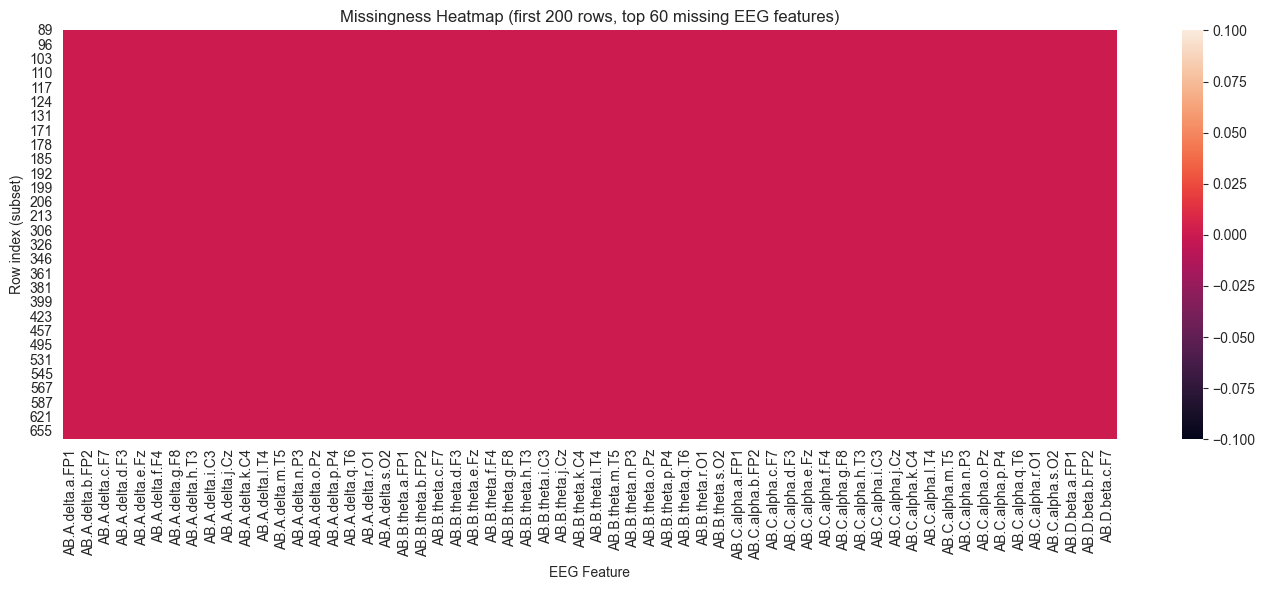


📈 Per-feature summary statistics (EEG features)
Top 10 features by missingness:
            feature  missing_pct     mean      std     min      p25   median  \
0  AB.A.delta.a.FP1          0.0  19.8580  10.8185  3.2723  12.6145  16.6814   
1  AB.A.delta.b.FP2          0.0  21.3883  13.0046  3.2442  12.5367  17.7209   
2   AB.A.delta.c.F7          0.0  17.0834   9.2700  3.0505  10.8532  15.0461   
3   AB.A.delta.d.F3          0.0  18.7497   9.2591  3.4126  12.3119  16.6835   
4   AB.A.delta.e.Fz          0.0  20.1422   9.7202  5.0666  13.7564  17.5332   
5   AB.A.delta.f.F4          0.0  19.2667   9.5917  4.0489  12.4609  17.0404   
6   AB.A.delta.g.F8          0.0  17.2330   9.6140  2.5522  10.4222  14.9165   
7   AB.A.delta.h.T3          0.0  11.2169   6.8482  2.1290   6.9893   9.5801   
8   AB.A.delta.i.C3          0.0  16.1179   8.4082  2.2135  10.6827  14.0528   
9   AB.A.delta.j.Cz          0.0  19.3149   9.2060  3.1493  13.2048  16.8074   

       p75       max  
0  23.7356   72

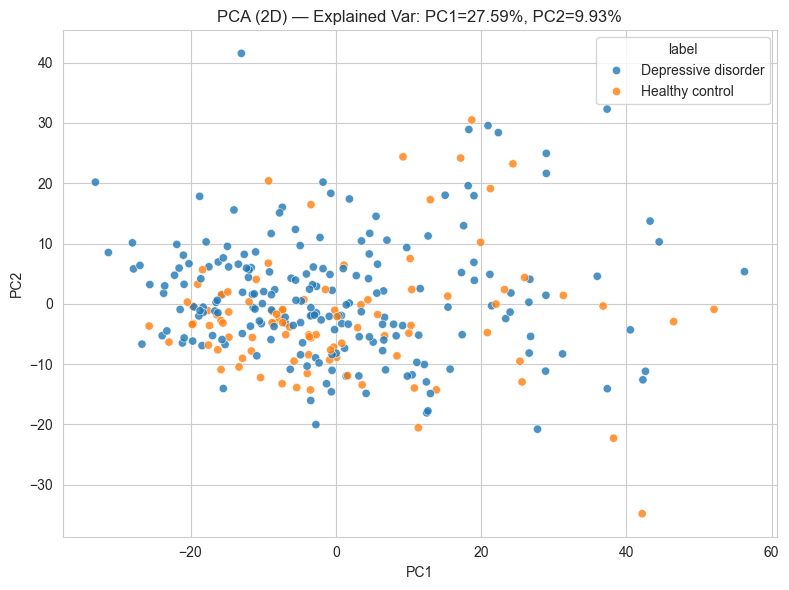

f:\MLOps\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


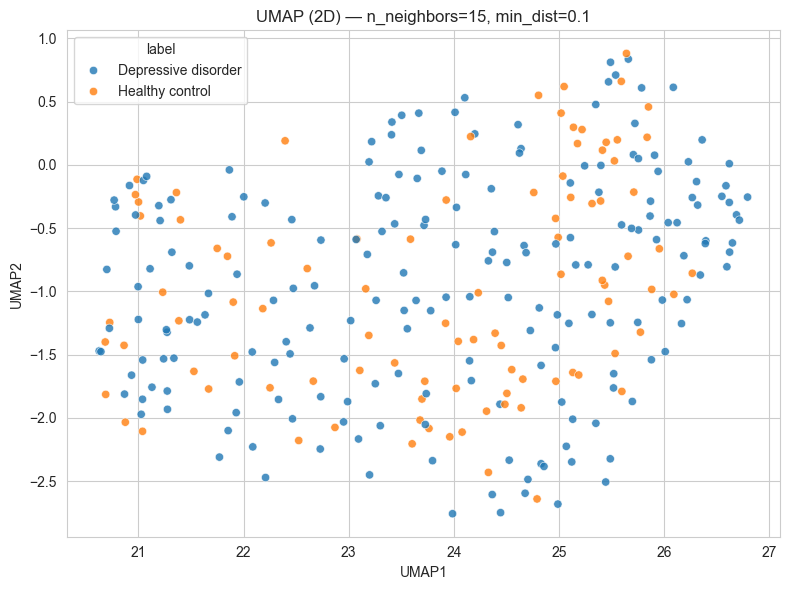

In [12]:
from sklearn.decomposition import PCA

def perform_eda(filepath="../dataset/EEG.csv",
                top_missing_cols=60,
                heatmap_rows=200,
                heatmap_cols=60,
                pca_max_features=1024,
                do_umap=True,
                umap_n_neighbors=15,
                umap_min_dist=0.1,
                random_state=42):

    print("Starting Exploratory Data Analysis...")

    # Load
    df = pd.read_csv(filepath)
    df = df.drop(columns=["Unnamed: 122"], errors="ignore")  # drop known junk

    # Filter target classes
    target_classes = ["Depressive disorder", "Healthy control"]
    if "specific.disorder" not in df.columns:
        raise ValueError("Column 'specific.disorder' not found in dataset.")
    df_filtered = df[df["specific.disorder"].isin(target_classes)].copy()

    print(f"Rows after filter: {len(df_filtered)}")
    print("Class counts:\n", df_filtered["specific.disorder"].value_counts())

    sns.set_style("whitegrid")

    # -------------------------
    # Existing demographic plots
    # -------------------------
    # Count plot
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(
        data=df_filtered,
        y="specific.disorder",
        order=target_classes,
        hue="specific.disorder",
        palette="viridis",
    )
    ax.set_title("Distribution of Specific Disorders")
    ax.set_xlabel("Count")
    ax.set_ylabel("Disorder")
    for container in ax.containers:
        ax.bar_label(container)
    leg = ax.get_legend()
    if leg:
        leg.remove()
    plt.tight_layout()
    plt.show()

    # Age
    if "age" in df_filtered.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(
            data=df_filtered,
            x="age",
            hue="specific.disorder",
            kde=True,
            bins=20,
            palette="coolwarm",
        )
        plt.title("Age Distribution by Disorder")
        plt.xlabel("Age (Years)")
        plt.tight_layout()
        plt.show()

    # Gender
    gender_col = "sex" if "sex" in df_filtered.columns else ("gender" if "gender" in df_filtered.columns else None)
    if gender_col:
        plt.figure(figsize=(6, 5))
        sns.countplot(data=df_filtered, x=gender_col, hue="specific.disorder", palette="pastel")
        plt.title("Gender Distribution by Disorder")
        plt.xlabel("Gender")
        plt.tight_layout()
        plt.show()

    # Education
    if "education" in df_filtered.columns:
        tmp = df_filtered.copy()
        tmp["education"] = pd.to_numeric(tmp["education"], errors="coerce")
        plt.figure(figsize=(10, 5))
        sns.histplot(
            data=tmp.dropna(subset=["education"]),
            x="education",
            hue="specific.disorder",
            bins=20,
            kde=False,
            palette="magma",
        )
        plt.title("Education Distribution (Years) by Disorder")
        plt.xlabel("Years of Education")
        plt.tight_layout()
        plt.show()

    # IQ
    if "IQ" in df_filtered.columns:
        tmp = df_filtered.copy()
        tmp["IQ"] = pd.to_numeric(tmp["IQ"], errors="coerce")
        plt.figure(figsize=(10, 5))
        sns.histplot(
            data=tmp.dropna(subset=["IQ"]),
            x="IQ",
            hue="specific.disorder",
            kde=True,
            element="step",
            palette="Set2",
        )
        plt.title("IQ Distribution by Disorder")
        plt.xlabel("IQ Score")
        plt.tight_layout()
        plt.show()

    # -------------------------
    # EEG feature columns
    # -------------------------
    meta_cols = ["no.", "sex", "age", "eeg.date", "education", "IQ", "main.disorder", "specific.disorder"]
    feature_cols = [c for c in df_filtered.columns if c not in meta_cols]
    # Make sure features are numeric (defensive)
    df_filtered[feature_cols] = df_filtered[feature_cols].apply(pd.to_numeric, errors="coerce")

    # ============================================================
    # 1) Missingness heatmap + missingness summaries
    # ============================================================
    print("\n🧩 Missingness analysis (EEG features)")

    missing_pct = df_filtered[feature_cols].isna().mean().sort_values(ascending=False)
    print("Top missing feature columns (%):")
    print((missing_pct.head(top_missing_cols) * 100).round(2))

    # Bar plot: top missingness columns
    top_missing = missing_pct.head(top_missing_cols)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=(top_missing.values * 100), y=top_missing.index)
    plt.title(f"Top {top_missing_cols} EEG Feature Columns by Missingness")
    plt.xlabel("Missing %")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Heatmap: show missingness matrix for top-missing columns (subset for readability)
    heat_cols = top_missing.index[:heatmap_cols].tolist()
    heat_rows = min(heatmap_rows, len(df_filtered))
    miss_matrix = df_filtered[heat_cols].isna().iloc[:heat_rows]

    plt.figure(figsize=(14, 6))
    sns.heatmap(miss_matrix, cbar=True)
    plt.title(f"Missingness Heatmap (first {heat_rows} rows, top {len(heat_cols)} missing EEG features)")
    plt.xlabel("EEG Feature")
    plt.ylabel("Row index (subset)")
    plt.tight_layout()
    plt.show()

    # ============================================================
    # 2) Per-feature summary stats (global + by class)
    # ============================================================
    print("\n📈 Per-feature summary statistics (EEG features)")
    stats = pd.DataFrame({
        "feature": feature_cols,
        "missing_pct": df_filtered[feature_cols].isna().mean().values,
        "mean": df_filtered[feature_cols].mean(skipna=True).values,
        "std": df_filtered[feature_cols].std(skipna=True).values,
        "min": df_filtered[feature_cols].min(skipna=True).values,
        "p25": df_filtered[feature_cols].quantile(0.25).values,
        "median": df_filtered[feature_cols].median(skipna=True).values,
        "p75": df_filtered[feature_cols].quantile(0.75).values,
        "max": df_filtered[feature_cols].max(skipna=True).values,
    }).sort_values("missing_pct", ascending=False)

    print("Top 10 features by missingness:")
    print(stats.head(10).round(4))

    print("\nTop 10 features by variance (std):")
    print(stats.sort_values("std", ascending=False).head(10).round(4))

    # Optional: by-class mean/std for a small subset (e.g., top variance features)
    top_var_feats = stats.sort_values("std", ascending=False)["feature"].head(20).tolist()
    by_class_means = df_filtered.groupby("specific.disorder")[top_var_feats].mean(numeric_only=True)
    by_class_stds  = df_filtered.groupby("specific.disorder")[top_var_feats].std(numeric_only=True)

    print("\nBy-class mean (top 20 variance features):")
    print(by_class_means.round(4))
    print("\nBy-class std (top 20 variance features):")
    print(by_class_stds.round(4))

    # ============================================================
    # 3) PCA + optional UMAP (2D) to visualize separation
    # ============================================================
    print("\n PCA / UMAP projection (2D)")

    # Build X for embedding:
    # - fill NaNs with column means (for visualization only)
    X = df_filtered[feature_cols].copy()
    X = X.fillna(X.mean(numeric_only=True))

    # Limit dimensionality for speed (optional)
    if X.shape[1] > pca_max_features:
        X = X.iloc[:, :pca_max_features]

    y = df_filtered["specific.disorder"].values

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X.values)

    # PCA 2D
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(Xs)
    explained = pca.explained_variance_ratio_ * 100

    pca_df = pd.DataFrame({
        "PC1": X_pca[:, 0],
        "PC2": X_pca[:, 1],
        "label": y
    })

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", alpha=0.8)
    plt.title(f"PCA (2D) — Explained Var: PC1={explained[0]:.2f}%, PC2={explained[1]:.2f}%")
    plt.tight_layout()
    plt.show()

    # UMAP 2D (optional, requires umap-learn)
    if do_umap:
        try:
            import umap
            reducer = umap.UMAP(
                n_components=2,
                n_neighbors=umap_n_neighbors,
                min_dist=umap_min_dist,
                random_state=random_state,
            )
            X_umap = reducer.fit_transform(Xs)

            umap_df = pd.DataFrame({
                "UMAP1": X_umap[:, 0],
                "UMAP2": X_umap[:, 1],
                "label": y
            })

            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="label", alpha=0.8)
            plt.title(f"UMAP (2D) — n_neighbors={umap_n_neighbors}, min_dist={umap_min_dist}")
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("⚠️ UMAP skipped: 'umap-learn' is not installed. Install with: pip install umap-learn")

    return stats  # return per-feature stats table for downstream use


# Run on your uploaded dataset
feature_stats = perform_eda("../dataset/EEG.csv")

Analyzing Feature Importance...
Fitting DT on TRAIN split only (n=264)

📊 Feature Selection Statistics:
   - Total Features Available: 1140
   - Features with Importance > 0.0001 (Model 2): 24
   - Features with Importance > 0.001  (Model 3): 24


C:\Users\nirav\AppData\Local\Temp\ipykernel_21916\2990995374.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_plot, palette="viridis")


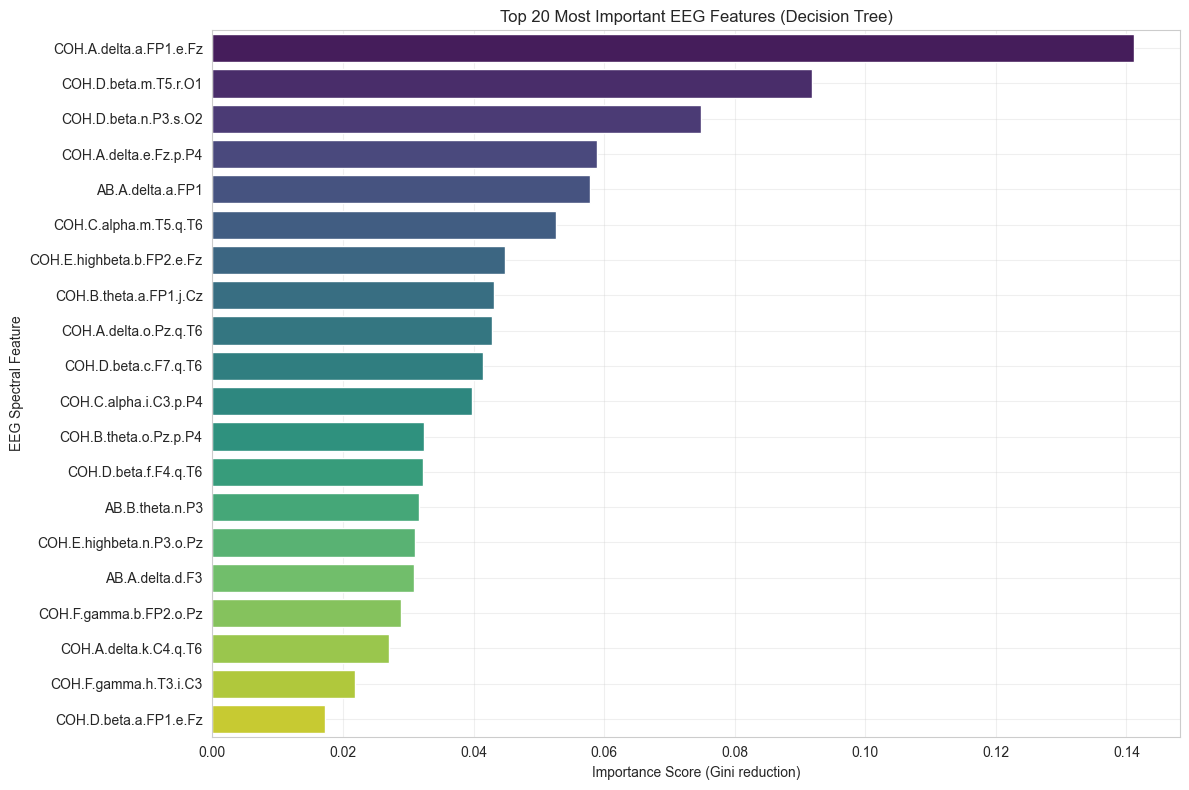

In [ ]:

def analyze_feature_importance(
    filepath="../dataset/EEG.csv",
    top_n=20,
    use_train_only=True,
    test_size=0.10,
    random_state=42
):
    """
    Decision-tree feature importance for interpretability.

    Improvements vs your version:
    - Drops known junk column: 'Unnamed: 122'
    - Drops metadata columns
    - Ensures numeric features
    - Optionally fits on TRAIN ONLY to avoid test leakage in analysis
    """
    print("Analyzing Feature Importance...")

    # 1) Load
    df = pd.read_csv(filepath)
    df = df.drop(columns=["Unnamed: 122"], errors="ignore")  # <-- drop junk all-NaN col if present

    # 2) Filter target classes
    target_classes = ["Depressive disorder", "Healthy control"]
    if "specific.disorder" not in df.columns:
        raise ValueError("Column 'specific.disorder' not found.")

    df = df[df["specific.disorder"].isin(target_classes)].copy()

    # 3) Drop metadata
    drop_cols = [
        "no.", "sex", "age", "eeg.date", "education", "IQ",
        "main.disorder", "specific.disorder"
    ]
    feature_df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    y = df["specific.disorder"].values

    # 4) Ensure numeric
    feature_df = feature_df.apply(pd.to_numeric, errors="coerce")

    # If anything is missing (shouldn’t be for EEG after dropping Unnamed: 122), fill with column means
    if feature_df.isna().any().any():
        feature_df = feature_df.fillna(feature_df.mean(numeric_only=True))

    X = feature_df.values.astype(np.float32)
    feature_names = feature_df.columns.tolist()

    # 5) Optional: fit on train only (recommended)
    if use_train_only:
        X_train, _, y_train, _ = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        X_fit, y_fit = X_train, y_train
        print(f"Fitting DT on TRAIN split only (n={len(y_fit)})")
    else:
        X_fit, y_fit = X, y
        print(f"Fitting DT on ALL filtered data (n={len(y_fit)})")

    # 6) Train Decision Tree
    dt = DecisionTreeClassifier(random_state=random_state)
    dt.fit(X_fit, y_fit)

    # 7) Feature importances
    importances = dt.feature_importances_
    feat_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    feat_df = feat_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    # 8) Stats (you had Model 2/3 thresholds)
    count_model_2 = int((feat_df["Importance"] > 1e-4).sum())
    count_model_3 = int((feat_df["Importance"] > 1e-3).sum())

    print("\n📊 Feature Selection Statistics:")
    print(f"   - Total Features Available: {len(feat_df)}")
    print(f"   - Features with Importance > 0.0001 (Model 2): {count_model_2}")
    print(f"   - Features with Importance > 0.001  (Model 3): {count_model_3}")

    # 9) Plot top N (only if there is any non-zero importance)
    top_plot = feat_df.head(top_n)
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=top_plot, palette="viridis")
    plt.title(f"Top {top_n} Most Important EEG Features (Decision Tree)")
    plt.xlabel("Importance Score (Gini reduction)")
    plt.ylabel("EEG Spectral Feature")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return feat_df, count_model_2, count_model_3


feature_ranking, count_m2, count_m3 = analyze_feature_importance(
    filepath="../dataset//EEG.csv",
    top_n=20,
    use_train_only=True
)

In [ ]:
def prepare_tensors_no_smote(X, y, config):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=config["TEST_SIZE"],
        random_state=config["SEED"],
        stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # fit on train
    X_test = scaler.transform(X_test)

    img = config["IMAGE_SIZE"]
    expected_dim = img * img
    if X_train.shape[1] != expected_dim:
        raise ValueError(f"Expected {expected_dim} features for {img}x{img} reshape, got {X_train.shape[1]}")

    X_train_img = X_train.reshape(-1, 1, img, img).astype(np.float32)
    X_test_img = X_test.reshape(-1, 1, img, img).astype(np.float32)

    train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train_img), torch.from_numpy(y_train).long())
    test_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_test_img), torch.from_numpy(y_test).long())

    # class weights for weighted CE
    classes = np.unique(y_train)
    w = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weights = torch.tensor(w, dtype=torch.float32)

    return train_ds, test_ds, scaler, class_weights

In [ ]:
class HybridCNNLSTM(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        num_classes: int = 2,
        cnn_channels=(64, 128),
        lstm_hidden: int = 64,
        lstm_layers: int = 1,
        bidirectional: bool = False,
        dropout_cnn: float = 0.25,
        dropout_fc: float = 0.30,
    ):
        super().__init__()

        c1, c2 = cnn_channels

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Dropout(dropout_cnn),
        )

        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.bidirectional = bidirectional
        self._lstm = None  # lazy init

        lstm_out_dim = lstm_hidden * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(lstm_out_dim, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_fc),
            nn.Linear(32, num_classes),
        )

    def _build_lstm_if_needed(self, cnn_out: torch.Tensor):
        if self._lstm is not None:
            return
        _, C, Hs, Ws = cnn_out.shape
        lstm_input_size = C * Ws
        self._lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=self.lstm_hidden,
            num_layers=self.lstm_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
        ).to(cnn_out.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn(x)  # (B,C,H',W')
        self._build_lstm_if_needed(cnn_out)

        B, C, Hs, Ws = cnn_out.shape
        seq = cnn_out.permute(0, 2, 1, 3).contiguous().view(B, Hs, C * Ws)

        lstm_out, _ = self._lstm(seq)
        last = lstm_out[:, -1, :]
        return self.fc(last)


# ============================================================
# Evaluation (uses passed criterion)
# ============================================================


# ============================================================
# Training pipeline (MLflow + early stopping)

Loading ../dataset/EEG.csv...
No missing values found.
Final Feature Matrix: (294, 1024)
Analyzing Feature Importance...
Fitting DT on TRAIN split only (n=264)

📊 Feature Selection Statistics:
   - Total Features Available: 1140
   - Features with Importance > 0.0001 (Model 2): 24
   - Features with Importance > 0.001  (Model 3): 24


C:\Users\nirav\AppData\Local\Temp\ipykernel_21916\2990995374.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=top_plot, palette="viridis")


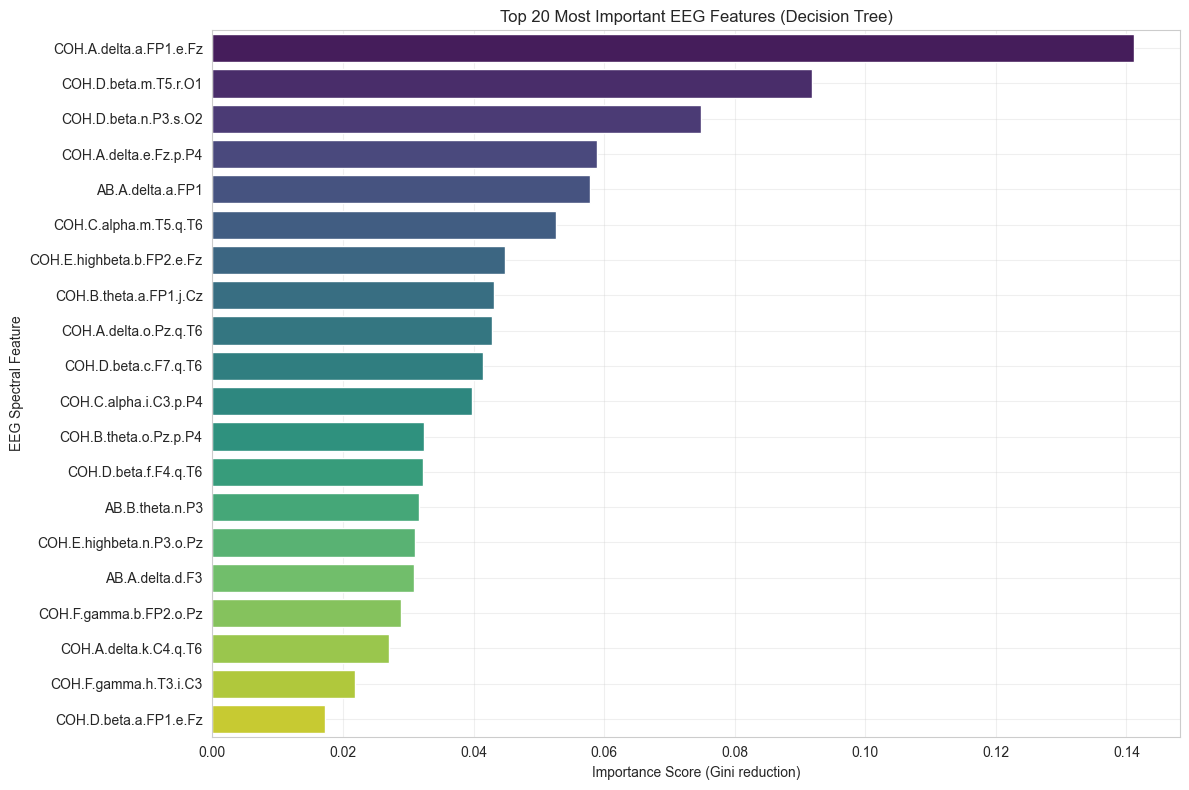

 Training Class Dist (Before SMOTE): [179  85]
 Training Class Dist (After SMOTE):  [179 179]


2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/07 11:04:34 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/07 11:04:34 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/07 11:04:34 INFO mlflow.store.db.utils: Updating database tables
2026/02/07 11:04:34 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/07 11:04:34 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/07 11:04:35 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/07 11:0

Starting MLOps Run: Run_20260207-110435
Epoch 5/50 | Train Acc: 0.740 | Val Acc: 0.700 | Train Loss: 0.5933 | Val Loss: 0.6286
Epoch 10/50 | Train Acc: 0.835 | Val Acc: 0.667 | Train Loss: 0.4066 | Val Loss: 0.6047
Epoch 15/50 | Train Acc: 0.925 | Val Acc: 0.667 | Train Loss: 0.2299 | Val Loss: 0.7996
Epoch 20/50 | Train Acc: 0.972 | Val Acc: 0.633 | Train Loss: 0.1155 | Val Loss: 0.9461
Epoch 25/50 | Train Acc: 0.939 | Val Acc: 0.633 | Train Loss: 0.1436 | Val Loss: 1.1299
Epoch 30/50 | Train Acc: 0.980 | Val Acc: 0.633 | Train Loss: 0.0672 | Val Loss: 1.1646
Epoch 35/50 | Train Acc: 0.983 | Val Acc: 0.667 | Train Loss: 0.0515 | Val Loss: 1.1108
Epoch 40/50 | Train Acc: 0.983 | Val Acc: 0.767 | Train Loss: 0.0387 | Val Loss: 1.1686
Epoch 45/50 | Train Acc: 1.000 | Val Acc: 0.700 | Train Loss: 0.0122 | Val Loss: 1.1204


2026/02/07 11:04:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/07 11:04:40 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/07 11:04:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 50/50 | Train Acc: 0.997 | Val Acc: 0.667 | Train Loss: 0.0212 | Val Loss: 1.3989


2026/02/07 11:04:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Training Complete. Best Validation Accuracy: 0.800


In [ ]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Determinism (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluate_model(model, loader, device, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * yb.size(0)
            total += yb.size(0)

            preds = torch.argmax(logits, dim=1)
            y_true.append(yb.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    avg_loss = total_loss / max(total, 1)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc, y_true, y_pred

def train_pipeline():
    set_seed(CONFIG["SEED"])

    # -------------------------
    # MLflow Tracking (SQLite)
    # Start UI from project root:
    #   mlflow ui --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlartifacts --port 5000
    # -------------------------
    mlflow.set_tracking_uri("sqlite:///mlflow.db")
    mlflow.set_experiment("EEG_Depression_Screening")

    DATA_PATH = "../dataset/EEG.csv"
    ART_DIR = "artifacts"
    CKPT_DIR = "models"
    os.makedirs(ART_DIR, exist_ok=True)
    os.makedirs(CKPT_DIR, exist_ok=True)

    # 1) Data
    processor = EEGProcessor(DATA_PATH, target_dim=CONFIG["IMAGE_SIZE"] ** 2)
    X, y = processor.load_and_process()

    # Feature importance (interpretability only)
    feat_df, count_m2, count_m3 = analyze_feature_importance(
        filepath=DATA_PATH,
        top_n=20,
        use_train_only=True,
        test_size=CONFIG["TEST_SIZE"],
        random_state=CONFIG["SEED"],
    )

    # Prepare tensors (NO SMOTE)
    train_ds, test_ds, scaler, class_weights = prepare_tensors_no_smote(X, y, CONFIG)

    train_loader = DataLoader(train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)

    # 2) Model + optimizer + criterion
    model = HybridCNNLSTM().to(CONFIG["DEVICE"])

    optimizer = optim.Adam(
        model.parameters(),
        lr=CONFIG["LEARNING_RATE"],
        weight_decay=CONFIG["WEIGHT_DECAY"]
    )

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(CONFIG["DEVICE"]))

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=CONFIG["LR_PLATEAU_FACTOR"],
        patience=CONFIG["LR_PLATEAU_PATIENCE"]
    )

    # Paths
    best_ckpt_path = os.path.join(CKPT_DIR, "best_model_state_dict.pth")
    scaler_path = os.path.join(ART_DIR, "scaler.joblib")
    feat_path = os.path.join(ART_DIR, "feature_importance.csv")
    report_path = os.path.join(ART_DIR, "classification_report.json")
    cm_path = os.path.join(ART_DIR, "confusion_matrix.npy")

    # Early stopping
    best_val_acc = -1.0
    best_epoch = -1
    bad = 0
    patience = CONFIG["EARLY_STOP_PATIENCE"]

    run_name = f"Run_{time.strftime('%Y%m%d-%H%M%S')}"
    print(f"Starting MLOps Run: {run_name}")

    with mlflow.start_run(run_name=run_name):
        # Log params
        cfg_to_log = dict(CONFIG)
        cfg_to_log["DEVICE"] = str(cfg_to_log["DEVICE"])
        mlflow.log_params(cfg_to_log)

        # Log feature-importance stats
        mlflow.log_param("dt_features_gt_1e-4", count_m2)
        mlflow.log_param("dt_features_gt_1e-3", count_m3)

        # Save + log artifacts: scaler + feature importances
        joblib.dump(scaler, scaler_path)
        feat_df.to_csv(feat_path, index=False)
        mlflow.log_artifact(scaler_path)
        mlflow.log_artifact(feat_path)

        # Training loop
        for epoch in range(CONFIG["EPOCHS"]):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb = xb.to(CONFIG["DEVICE"], non_blocking=True)
                yb = yb.to(CONFIG["DEVICE"], non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * yb.size(0)
                total += yb.size(0)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()

            train_loss = running_loss / max(total, 1)
            train_acc = correct / max(total, 1)

            # Validation
            val_loss, val_acc, _, _ = evaluate_model(model, test_loader, CONFIG["DEVICE"], criterion)

            scheduler.step(val_loss)

            # Log metrics
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_acc", train_acc, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_acc", val_acc, step=epoch)
            mlflow.log_metric("lr", optimizer.param_groups[0]["lr"], step=epoch)

            if (epoch + 1) % 5 == 0:
                print(
                    f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | "
                    f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
                    f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
                )

            # Checkpoint + early stopping
            if val_acc > best_val_acc + 1e-4:
                best_val_acc = val_acc
                best_epoch = epoch
                bad = 0
                torch.save({"state_dict": model.state_dict(), "config": cfg_to_log}, best_ckpt_path)
                mlflow.log_artifact(best_ckpt_path)
            else:
                bad += 1
                if bad >= patience:
                    print(f"Early stopping at epoch {epoch+1} | best_epoch={best_epoch+1} | best_val_acc={best_val_acc:.3f}")
                    break

        mlflow.log_param("best_epoch", best_epoch + 1)
        mlflow.log_metric("best_val_acc", best_val_acc)

        # Reload best checkpoint for final report
        ckpt = torch.load(best_ckpt_path, map_location=CONFIG["DEVICE"])
        model.load_state_dict(ckpt["state_dict"])

        val_loss, val_acc, y_true, y_pred = evaluate_model(model, test_loader, CONFIG["DEVICE"], criterion)

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)

        np.save(cm_path, cm)
        with open(report_path, "w") as f:
            json.dump(report, f, indent=2)

        mlflow.log_artifact(cm_path)
        mlflow.log_artifact(report_path)

        # Log model (compat across MLflow versions)
        try:
            mlflow.pytorch.log_model(model, name="model")
        except TypeError:
            mlflow.pytorch.log_model(model, artifact_path="model")

        print(f"Training Complete. Best Val Acc: {best_val_acc:.3f} @ epoch {best_epoch+1}")


if __name__ == "__main__":
    train_pipeline()

In [17]:
import mlflow
print("tracking_uri:", mlflow.get_tracking_uri())

tracking_uri: sqlite:///mlflow.db


In [ ]:
mlflow ui --backend-store-uri code/mlruns --host 0.0.0.0 --port 5000